<a href="https://colab.research.google.com/github/engdorm/deeplearningex1/blob/main/Ex1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup

In [1]:
import numpy as np
from datetime import datetime 

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

from torchvision import datasets, transforms

import matplotlib.pyplot as plt

# check device
DEVICE = 'cuda' # if torch.cuda.is_available() else 'cpu'

%config InlineBackend.figure_format = 'retina'

# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 32
N_EPOCHS = 15
W_D = 0

IMG_SIZE = 32
N_CLASSES = 10

Helper functions

In [2]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_acc(train_acces, valid_acces):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_acces = np.array(train_acces) 
    valid_acces = np.array(valid_acces)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_acces, color='blue', label='Training accuracy') 
    ax.plot(valid_acces, color='red', label='Validation accuracy')
    ax.set(title="Accuracy over epochs", 
            xlabel='Epoch',
            ylabel='Accuracy') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for X, y_true in valid_loader:
    
        X = X.to(device)
        y_true = y_true.to(device)

        # Forward pass and record loss
        y_hat, _ = model(X) 
        loss = criterion(y_hat, y_true) 
        running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    train_acces = []
    valid_acces = []
 
    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
        train_losses.append(train_loss)

        # validation
        with torch.no_grad():
            model, valid_loss = validate(valid_loader, model, criterion, device)
            valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            
            train_acc = get_accuracy(model, train_loader, device=device)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            train_acces.append(100 * train_acc)
            valid_acces.append(100 * valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_acc(train_acces, valid_acces)
    
    return model, optimizer, (train_losses, valid_losses)

Data

In [3]:
# define transforms
# transforms.ToTensor() automatically scales the images to [0,1] range
transforms = transforms.Compose([transforms.Resize((32, 32)),
                                 transforms.ToTensor()])

# download and create datasets
train_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', 
                               train=True, 
                               transform=transforms,
                               download=True)

valid_dataset = datasets.FashionMNIST(root='./data/FashionMNIST', 
                               train=False, 
                               transform=transforms)

# define the data loaders
train_loader = DataLoader(dataset=train_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True)

valid_loader = DataLoader(dataset=valid_dataset, 
                          batch_size=BATCH_SIZE, 
                          shuffle=False)


Extracting ./data/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw




Extracting ./data/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/FashionMNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Plotting the images

Text(0.5, 0.98, 'MNIST Dataset - preview')

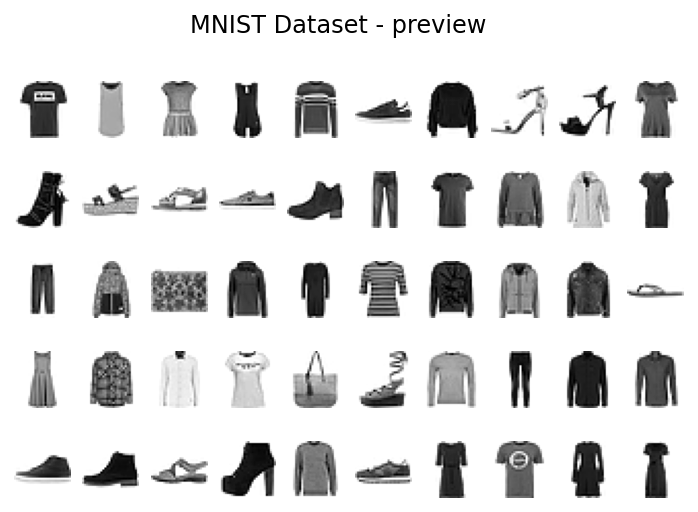

In [4]:
ROW_IMG = 10
N_ROWS = 5
fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(train_dataset.data[index], cmap='gray_r')
fig.suptitle('MNIST Dataset - preview')

Implementing LeNet-5

08:07:56 --- Epoch: 0	Train loss: 0.5714	Valid loss: 0.4727	Train accuracy: 83.93	Valid accuracy: 82.75
08:08:29 --- Epoch: 1	Train loss: 0.3966	Valid loss: 0.3934	Train accuracy: 87.23	Valid accuracy: 85.58
08:09:02 --- Epoch: 2	Train loss: 0.3484	Valid loss: 0.3781	Train accuracy: 87.83	Valid accuracy: 85.72
08:09:35 --- Epoch: 3	Train loss: 0.3202	Valid loss: 0.3833	Train accuracy: 87.49	Valid accuracy: 85.55
08:10:09 --- Epoch: 4	Train loss: 0.2985	Valid loss: 0.3464	Train accuracy: 89.76	Valid accuracy: 87.36
08:10:41 --- Epoch: 5	Train loss: 0.2793	Valid loss: 0.3298	Train accuracy: 90.66	Valid accuracy: 88.09
08:11:15 --- Epoch: 6	Train loss: 0.2653	Valid loss: 0.3353	Train accuracy: 91.00	Valid accuracy: 87.94
08:11:48 --- Epoch: 7	Train loss: 0.2508	Valid loss: 0.3326	Train accuracy: 91.27	Valid accuracy: 88.41
08:12:20 --- Epoch: 8	Train loss: 0.2402	Valid loss: 0.3242	Train accuracy: 91.74	Valid accuracy: 88.37
08:12:54 --- Epoch: 9	Train loss: 0.2281	Valid loss: 0.3365	Trai

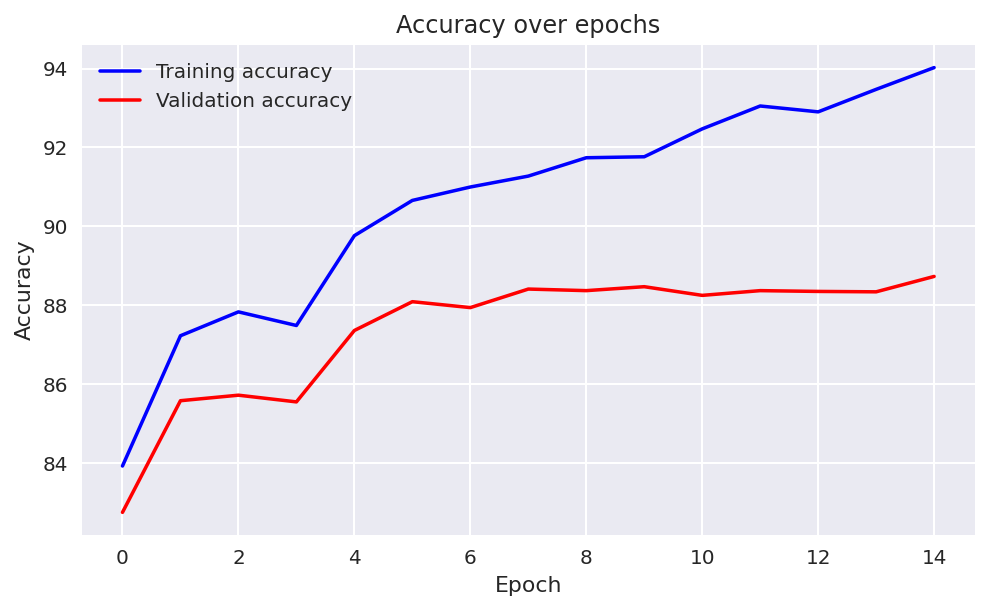

In [5]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(
#            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
#            nn.BatchNorm2d(6),            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
#            nn.BatchNorm2d(16),            
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh(),
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
#            nn.Dropout(0.5),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=W_D)
criterion = nn.CrossEntropyLoss()

model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, valid_loader, N_EPOCHS, DEVICE)

Evaluating the predictions

Text(0.5, 0.98, 'LeNet-5 - predictions')

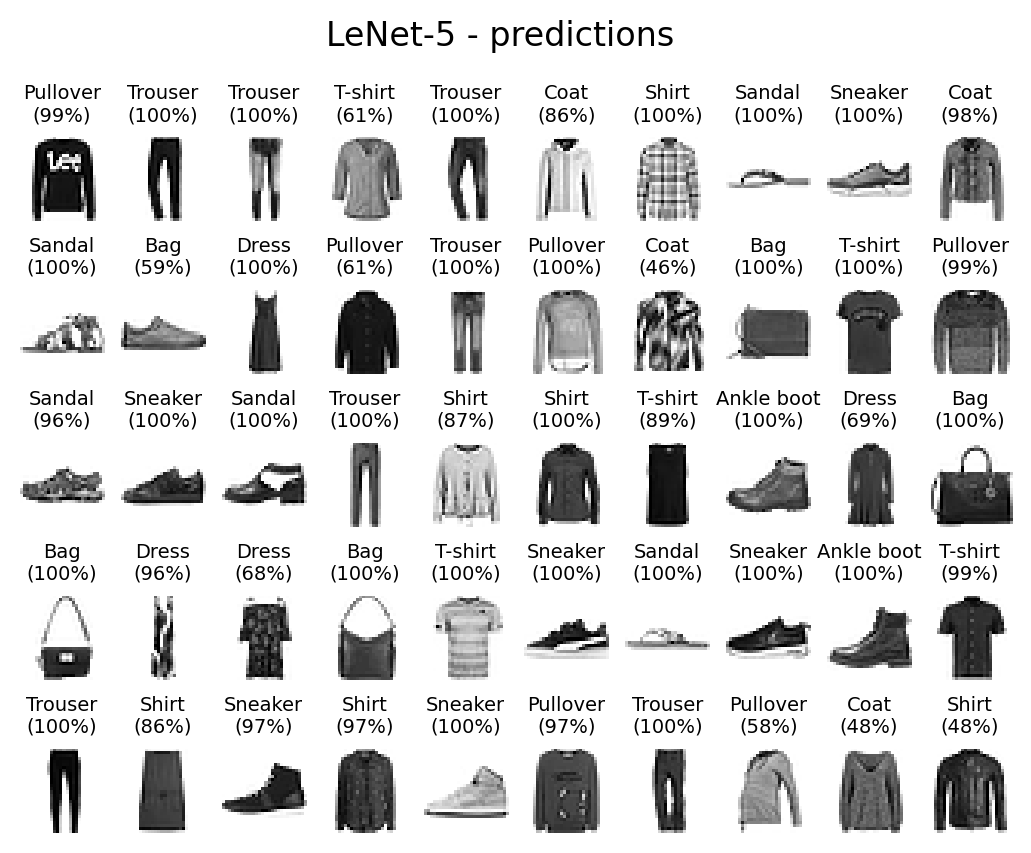

In [ ]:
ROW_IMG = 10
N_ROWS = 5

fig = plt.figure()
for index in range(1, ROW_IMG * N_ROWS + 1):
    plt.subplot(N_ROWS, ROW_IMG, index)
    plt.axis('off')
    plt.imshow(valid_dataset.data[index], cmap='gray_r')
    
    with torch.no_grad():
        model.eval()
        _, probs = model(valid_dataset[index][0].unsqueeze(0).cuda())
      
    names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']    
    title = f'{names[torch.argmax(probs)]}\n({torch.max(probs * 100):.0f}%)'
    
    plt.title(title, fontsize=7)
fig.suptitle('LeNet-5 - predictions')

In [ ]:
# remove the downloaded dataset
# !rm -r mnist_data